![BYOMP-598.png](BYOMP-598.png)

In [2]:
# Install required packages
!pip install --quiet transformers datasets langchain sentence-transformers faiss-cpu torch numpy pandas matplotlib tqdm chromadb accelerate langchain_experimental langchain_openai langchain_cohere


In [1]:
import os
import json
import time
import re
import numpy as np
import pandas as pd
import torch
import faiss
from hashlib import sha256
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    TokenTextSplitter
)
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from langchain_openai import OpenAIEmbeddings
from langchain_cohere import CohereEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [2]:
def load_quality_github_dataset():
    splits = {
        "train": "train.jsonl",
    }
    dataset = {}
    for split, filename in splits.items():
        with open(f"{filename}", "r", encoding="utf-8") as f:
            dataset[split] = [json.loads(line) for line in f]
    return dataset

def flatten_quality_dataset(dataset):
    """
    Flatten the QuALITY dataset to create one entry per question
    """
    flattened_dataset = {}

    for split_name, samples in dataset.items():
        flattened_samples = []
        if split_name == "test":
            continue
        for article_data in samples:
            article = article_data["article"]

            for question_data in article_data["questions"]:

                # Convert 1-indexed gold_label to 0-indexed

                gold_label_idx = question_data["gold_label"] - 1

                gold_label_letter = chr(65 + gold_label_idx)  # Convert to A, B, C, D

                flattened_samples.append({
                    "article": article,
                    "question": question_data["question"],
                    "options": question_data["options"],
                    "gold_label": gold_label_letter,  # Store as A, B, C, D
                    "article_id": article_data["article_id"],
                    "title": article_data.get("title", "")
                })

        flattened_dataset[split_name] = flattened_samples

    return flattened_dataset

In [3]:
from datasets import load_dataset
def load_wikiqa_dataset():
    dataset = load_dataset("wiki_qa")
    
    # WikiQA has different structure - we need to adapt it to our format
    formatted_data = {"train": [], "validation": [], "test": []}
    
    for split in ["train", "validation", "test"]:
        for example in dataset[split]:
            # Create fake "article" from question and candidate sentences
            context = f"Question: {example['question']}\n" + "\n".join(example['candidate_sentences'])
            
            formatted_data[split].append({
                "article": context,
                "question": example['question'],
                "options": example['candidate_sentences'],
                "gold_label": chr(65 + example['label']) if 'label' in example else None,
                "article_id": example['question_id'],
                "title": ""
            })
    
    return formatted_data

In [4]:
import random
from datasets import load_dataset

def load_squad():
    """Load and preprocess SQuAD v1.1 dataset"""
    dataset = load_dataset("squad")
    
    formatted_data = {"train": []}
    
    for split in ["train"]:
        for example in dataset[split]:
            # SQuAD is extractive QA - create multiple choice format
            context = example['context']
            question = example['question']
            
            # Get the correct answer
            answer_text = example['answers']['text'][0]  # Correct Answer text
            
            # Generate distractors from context
            sentences = [s.strip() for s in context.split('.') if s.strip()]
            # Filter out sentences containing the answer to avoid confusion
            distractor_candidates = [s for s in sentences if answer_text not in s]
            
            # If we don't have enough distractors, create some
            if len(distractor_candidates) < 3:
                while len(distractor_candidates) < 3:
                    distractor_candidates.append(f"Incorrect option {len(distractor_candidates)+1}")
            
            # Sample 3 distractors
            distractors = random.sample(distractor_candidates, 3)
            
            # Randomly place the correct answer among options
            correct_option_index = random.randint(0, 3)
            options = []
            
            for i in range(4):
                if i == correct_option_index:
                    options.append(answer_text)
                else:
                    options.append(distractors.pop(0))
            
            # Convert index to letter (0->A, 1->B, etc.)
            correct_option_label = chr(65 + correct_option_index)  # A, B, C, or D
            
            formatted_data[split].append({
                "article": context,
                "question": question,
                "options": options,
                "gold_label": correct_option_label,
                "article_id": example['id'],
                "title": example['title']
            })
    
    return formatted_data


In [5]:
# Chunking Strategies
class ChunkingStrategies:
    def __init__(self, semantic_model_name="all-MiniLM-L6-v2", provider_name="huggingface"):
        # Initialize embedding model for semantic chunking
        if provider_name=="huggingface":
          #self.embeddings = HuggingFaceEmbeddings(model_name= semantic_model_name) 
           self.embeddings = HuggingFaceBgeEmbeddings(
                model_name=semantic_model_name,
                model_kwargs={'device': 'cuda'},
                encode_kwargs={'normalize_embeddings': True}  # Critical for BGE
            )
        elif provider_name=="openai":
          self.embeddings = OpenAIEmbeddings()
    def fixed_size_no_overlap(self, text, chunk_size=512):
        """Fixed-size chunking with no overlap"""
        splitter = TokenTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=0
        )
        return splitter.split_text(text)

    def fixed_size_with_overlap_10(self, text, chunk_size=512):
        """Fixed-size chunking with 10% overlap"""
        overlap = int(chunk_size * 0.1)
        splitter = TokenTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=overlap
        )
        return splitter.split_text(text)

    def fixed_size_with_overlap_20(self, text, chunk_size=512):
        """Fixed-size chunking with 20% overlap"""
        overlap = int(chunk_size * 0.2)
        splitter = TokenTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=overlap
        )
        return splitter.split_text(text)

    def semantic_chunking(self, text):
        """Semantic chunking using LangChain's SemanticChunker"""
        try:
            splitter = SemanticChunker(self.embeddings)
            return splitter.split_text(text)
        except Exception as e:
            print(f"Error in semantic chunking: {e}")
            # Fallback to fixed-size chunking if semantic chunking fails
            return self.fixed_size_with_overlap_10(text)

    def sentence_based_chunking(self, text):
        """Sentence-based chunking"""
        splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", ".", "!", "?", ";", ":", " ", ""],
            chunk_size=512,
            chunk_overlap=50
        )
        return splitter.split_text(text)

In [6]:
class EmbeddingGenerator:
    def __init__(self, model_name="BAAI/bge-large-en", provider="huggingface"):
        """
        Initialize embedding generator using LangChain's interface

        Parameters:
            model_name (str): Name of the model to use
            provider (str): Provider - 'huggingface', 'openai', 'cohere', etc.
        """
        if provider == "huggingface":
            self.embeddings = HuggingFaceEmbeddings(
                model_name=model_name,
                model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"},
                encode_kwargs={"normalize_embeddings": True}
            )
        elif provider == "openai":
            self.embeddings = OpenAIEmbeddings(model=model_name)
        elif provider == "cohere":
            self.embeddings = CohereEmbeddings(model=model_name)

    def generate_embeddings(self, chunks):
        """Generate embeddings for a list of text chunks"""
        embeddings = self.embeddings.embed_documents(chunks)
        return np.array(embeddings, dtype=np.float32) if isinstance(embeddings, list) else embeddings

    def generate_question_embedding(self, question):
        """Generate embedding for a single question"""
        q_embedding = self.embeddings.embed_query(question)
        return np.array(q_embedding, dtype=np.float32) if isinstance(q_embedding, list) else q_embedding

In [7]:
# Vector Database
class VectorDatabase:
    def __init__(self, dimension):
        """
        Initialize a FAISS vector database with the specified dimension
        """
        self.index = faiss.IndexFlatL2(dimension)
        self.texts = []  # Store original texts
        self.seen_hashes = set()

    def add_embeddings(self, embeddings, texts):
        """
        Add embeddings and their corresponding texts to the database
        """
        if len(embeddings) == 0:
            return
        unique_emb = []
        unique_texts = []
        for emb, text in zip(embeddings, texts):
            text_hash = sha256(text.encode()).hexdigest()
            if text_hash not in self.seen_hashes:
                self.seen_hashes.add(text_hash)
                unique_emb.append(emb)
                unique_texts.append(text)

        # Convert to numpy array if it's not already
        if isinstance(unique_emb[0], torch.Tensor):
            unique_emb = [e.cpu().numpy() for e in unique_emb]

        # Add to FAISS index
        self.index.add(np.array(unique_emb).astype('float32'))

        # Store original texts
        self.texts.extend(unique_texts)

    def search(self, query_embedding, k=3):
        """
        Search for the k nearest neighbors of the query embedding
        Returns distances and indices
        """
        if isinstance(query_embedding, torch.Tensor):
            query_embedding = query_embedding.cpu().numpy()

        # Reshape if it's a single embedding
        if len(query_embedding.shape) == 1:
            query_embedding = query_embedding.reshape(1, -1)

        # Search
        distances, indices = self.index.search(
            np.array(query_embedding).astype('float32'), k
        )

        # Get the corresponding texts
        results = []
        for idx_list in indices:
            texts = [self.texts[idx] for idx in idx_list if idx < len(self.texts)]
            results.append(texts)

        return distances, results

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import re

class LLMGenerator:
    def __init__(self, model_name="meta-llama/Meta-Llama-3-8B-Instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token  # Set pad token
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto"
        )

    def generate_answer(self, context, question):
        # Format the prompt using the correct chat template
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Given the context below, respond with ONLY the letter (A, B, C, or D) of the correct answer.\n\nContext: {context}\n\nQuestion: {question}"}
        ]
        prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Tokenize and get input length
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        input_length = inputs.input_ids.shape[1]  # Get input token count
        
        # Generate only new tokens
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=1,  # Only generate 1 new token
                temperature=0.1,
                top_p=0.9,
                do_sample=True
            )
        
        # Extract ONLY the new tokens (skip input tokens)
        new_tokens = outputs[0][input_length:]
        response = self.tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
        return response.upper()


In [9]:
class Evaluator:
    def __init__(self):
        """
        Initialize the evaluator
        """
        pass

    def evaluate_answer(self, generated_answer, gold_answer, question_type="multiple_choice"):
        """
        Evaluate the generated answer against the gold answer
        gold_answer should be a letter (A, B, C, D)
        """
        if question_type == "multiple_choice":
            # Extract the letter choice from the generated answer
            match = re.search(r'[A-D]', generated_answer)
            if match:
                predicted_choice = match.group(0)
                correct = predicted_choice == gold_answer
            else:
                # If no letter is found, count as incorrect
                correct = False

            return {
                "accuracy": 1.0 if correct else 0.0
            }
        else:
            # For open-ended questions (not applicable for QuALITY)
            return {
                "semantic_similarity": 0.5  # Placeholder
            }



In [10]:
def specific_generate_and_save_vector_db(dataset, strategy_name, embedding_model_name="BAAI/bge-large-en", 
                               semantic_model_name="BAAI/bge-m3", num_samples=100, 
                               save_dir="vector_dbs", force_rebuild=False):
    """
    Generate a vector database for a specific chunking strategy and save it to disk,
    with text-based metrics output.

    Parameters:
        dataset: The flattened dataset containing documents
        strategy_name: Name of the specific chunking strategy to use
        embedding_model_name: Name of the embedding model to use
        semantic_model_name: Name of semantic model to use for semantic chunking strategy
        num_samples: Number of samples to process from training set
        save_dir: Directory to save the vector database
        force_rebuild: Whether to rebuild database even if it already exists

    Returns:
        Dictionary with the database path and metrics summary
    """
    print("WARNING: This is not the function generate and save db for all strategies, this function will not generate and save eval graphs, it will just rebuild return the metrics for select strategy.")
    # Initialize components
    chunking_strategies_obj = ChunkingStrategies(semantic_model_name=semantic_model_name)
    embedding_generator = EmbeddingGenerator(embedding_model_name)
    
    # Validate the strategy name
    chunking_methods = {
        "fixed_size_no_overlap": chunking_strategies_obj.fixed_size_no_overlap,
        "fixed_size_with_overlap_10": chunking_strategies_obj.fixed_size_with_overlap_10,
        "fixed_size_with_overlap_20": chunking_strategies_obj.fixed_size_with_overlap_20,
        "semantic_chunking": chunking_strategies_obj.semantic_chunking,
        "sentence_based_chunking": chunking_strategies_obj.sentence_based_chunking
    }
    
    if strategy_name not in chunking_methods:
        raise ValueError(f"Invalid strategy name: {strategy_name}. Available strategies: {list(chunking_methods.keys())}")
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate file path for the vector database
    filename = f"{strategy_name}_{embedding_model_name.replace('/', '_')}_{num_samples}.pkl"
    db_path = os.path.join(save_dir, filename)
    
    # Skip if database already exists and force_rebuild is False
    if os.path.exists(db_path) and not force_rebuild:
        print(f"Vector database for {strategy_name} already exists at {db_path}. Skipping...")
        return {"db_path": db_path}
    
    print(f"Building vector database for {strategy_name}...")
    
    # Get training samples
    train_samples = dataset["train"][:num_samples]
    
    # Initialize metrics tracking
    all_chunks = []
    all_embeddings = []
    total_chunks = 0
    total_chunking_time = 0
    total_embedding_time = 0
    chunk_sizes = []
    chunking_times = []
    embedding_times = []
    chunks_per_doc = []
    
    # Process each sample
    chunking_method = chunking_methods[strategy_name]
    for sample_idx, sample in enumerate(tqdm(train_samples, desc=f"Processing {strategy_name}")):
        context = sample["article"]
        
        # Apply chunking
        start_time = time.time()
        chunks = chunking_method(context)
        chunking_time = time.time() - start_time
        
        # Generate embeddings
        start_time = time.time()
        chunk_embeddings = embedding_generator.generate_embeddings(chunks)
        embedding_time = time.time() - start_time
        
        # Collect results
        all_chunks.extend(chunks)
        all_embeddings.extend(chunk_embeddings)
        
        # Update metrics
        chunk_count = len(chunks)
        total_chunks += chunk_count
        total_chunking_time += chunking_time
        total_embedding_time += embedding_time
        chunk_sizes.extend([len(chunk) for chunk in chunks])
        chunking_times.append(chunking_time)
        embedding_times.append(embedding_time)
        chunks_per_doc.append(chunk_count)
        
        # Print progress every 10 samples
        if (sample_idx + 1) % 10 == 0:
            print(f"  Processed {sample_idx + 1}/{len(train_samples)} samples")
    
    # Create vector database
    if len(all_embeddings) > 0:
        # Get dimension from first embedding
        if isinstance(all_embeddings[0], list):
            dimension = len(all_embeddings[0])
        else:
            dimension = all_embeddings[0].shape[0]
        
        # Create and populate vector database
        vector_db = VectorDatabase(dimension=dimension)
        vector_db.add_embeddings(all_embeddings, all_chunks)
        
        # Save vector database to disk
        with open(db_path, 'wb') as f:
            pickle.dump(vector_db, f)
        
        # Calculate and print metrics
        avg_chunks_per_doc = total_chunks / len(train_samples)
        avg_chunk_size = np.mean(chunk_sizes) if chunk_sizes else 0
        avg_chunking_time = np.mean(chunking_times) if chunking_times else 0
        avg_embedding_time = np.mean(embedding_times) if embedding_times else 0
        time_per_chunk = total_embedding_time / total_chunks if total_chunks > 0 else 0
        
        # Print metrics summary
        print("\n" + "="*50)
        print(f"METRICS SUMMARY FOR {strategy_name}")
        print("="*50)
        print(f"Total documents processed: {len(train_samples)}")
        print(f"Total chunks generated: {total_chunks}")
        print(f"Average chunks per document: {avg_chunks_per_doc:.2f}")
        print(f"Average chunk size: {avg_chunk_size:.2f} characters")
        print(f"Min chunk size: {min(chunk_sizes) if chunk_sizes else 0} characters")
        print(f"Max chunk size: {max(chunk_sizes) if chunk_sizes else 0} characters")
        print(f"Total chunking time: {total_chunking_time:.2f} seconds")
        print(f"Total embedding time: {total_embedding_time:.2f} seconds")
        print(f"Average chunking time per document: {avg_chunking_time:.4f} seconds")
        print(f"Average embedding time per document: {avg_embedding_time:.4f} seconds")
        print(f"Average time per chunk: {time_per_chunk:.4f} seconds")
        print(f"Vector database saved to: {db_path}")
        print("="*50)
        
        # Return metrics as a dictionary
        metrics = {
            "db_path": db_path,
            "total_chunks": total_chunks,
            "avg_chunks_per_doc": avg_chunks_per_doc,
            "avg_chunk_size": avg_chunk_size,
            "min_chunk_size": min(chunk_sizes) if chunk_sizes else 0,
            "max_chunk_size": max(chunk_sizes) if chunk_sizes else 0,
            "total_chunking_time": total_chunking_time,
            "total_embedding_time": total_embedding_time,
            "avg_chunking_time": avg_chunking_time,
            "avg_embedding_time": avg_embedding_time,
            "time_per_chunk": time_per_chunk
        }        
        return metrics
    else:
        print(f"No embeddings generated for {strategy_name}. Skipping database creation.")
        return {"db_path": None}


In [11]:
import os
import pickle
import time
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

def generate_and_save_vector_dbs(dataset, embedding_model_name="BAAI/bge-large-en",semantic_model_name="BAAI/bge-m3",  chunking_strategies=None,
                                 num_samples=100, save_dir="vector_dbs", force_rebuild=False):
    """
    Generate vector databases for each chunking strategy and save them to disk, 
    along with metrics visualization for performance analysis.

    Parameters:
        dataset: The flattened dataset containing documents
        embedding_model_name: Name of the embedding model to use
        semantic_model_name: Name of semantic model to use for semantic chunking strategy
        chunking_strategies: List of chunking strategies to evaluate (if None, uses all available)
        num_samples: Number of samples to process from training set
        save_dir: Directory to save the vector databases
        force_rebuild: Whether to rebuild databases even if they already exist

    Returns:
        Dictionary mapping strategy names to their saved file paths and metrics plots
    """
    # Initialize components
    chunking_strategies_obj = ChunkingStrategies(semantic_model_name = semantic_model_name)
    embedding_generator = EmbeddingGenerator(embedding_model_name)
    generated_db = False
    # Define chunking methods if not provided
    if chunking_strategies is None:
        chunking_strategies = [
            "fixed_size_no_overlap",
            "fixed_size_with_overlap_10",
            "fixed_size_with_overlap_20",
            "semantic_chunking",
            "sentence_based_chunking"
        ]

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create metrics directory
    metrics_dir = os.path.join(save_dir, "metrics")
    os.makedirs(metrics_dir, exist_ok=True)

    # Mapping between strategy names and methods
    chunking_methods = {
        "fixed_size_no_overlap": chunking_strategies_obj.fixed_size_no_overlap,
        "fixed_size_with_overlap_10": chunking_strategies_obj.fixed_size_with_overlap_10,
        "fixed_size_with_overlap_20": chunking_strategies_obj.fixed_size_with_overlap_20,
        "semantic_chunking": chunking_strategies_obj.semantic_chunking,
        "sentence_based_chunking": chunking_strategies_obj.sentence_based_chunking
    }

    # File paths for each vector database
    db_paths = {}
    for strategy in chunking_strategies:
        # Generate a unique filename based on strategy, model, and sample count
        filename = f"{strategy}_{embedding_model_name.replace('/', '_')}_{num_samples}.pkl"
        db_paths[strategy] = os.path.join(save_dir, filename)
    
    # Initialize metrics tracking data structures
    metrics = {
        "strategy": [],
        "sample_idx": [],
        "num_chunks": [],
        "avg_chunk_size": [],
        "max_chunk_size": [],
        "min_chunk_size": [],
        "chunking_time": [],
        "embedding_time": [],
        "time_per_chunk": [],
        "total_processing_time": []
    }
    
    # Strategy summary metrics
    strategy_metrics = defaultdict(lambda: {
        "total_chunks": 0,
        "total_chunking_time": 0,
        "total_embedding_time": 0,
        "num_documents": 0,
        "chunk_sizes": [],
        "chunking_times": [],
        "embedding_times": [],
        "chunks_per_doc": []
    })

    # Generate and save vector databases
    for strategy in chunking_strategies:
        db_path = db_paths[strategy]

        # Skip if database already exists and force_rebuild is False
        if os.path.exists(db_path) and not force_rebuild:
            print(f"Vector database for {strategy} already exists at {db_path}. Skipping...")
            continue
    
        print(f"Building vector database for {strategy}...")
        generated_db = True
        # Get training samples
        train_samples = dataset["train"][:num_samples]

        # Process each sample
        all_chunks = []
        all_embeddings = []

        # Process metrics
        total_chunks = 0
        total_chunking_time = 0
        total_embedding_time = 0

        for sample_idx, sample in enumerate(tqdm(train_samples, desc=f"Processing {strategy}")):
            context = sample["article"]

            # Apply chunking
            chunking_method = chunking_methods[strategy]
            start_time = time.time()
            chunks = chunking_method(context)
            chunking_time = time.time() - start_time

            # Generate embeddings
            start_time = time.time()
            chunk_embeddings = embedding_generator.generate_embeddings(chunks)
            embedding_time = time.time() - start_time

            # Collect results
            all_chunks.extend(chunks)
            all_embeddings.extend(chunk_embeddings)

            # Calculate chunk sizes
            chunk_sizes = [len(chunk) for chunk in chunks]
            avg_chunk_size = np.mean(chunk_sizes) if chunks else 0
            max_chunk_size = max(chunk_sizes) if chunks else 0
            min_chunk_size = min(chunk_sizes) if chunks else 0

            # Update detailed metrics
            metrics["strategy"].append(strategy)
            metrics["sample_idx"].append(sample_idx)
            metrics["num_chunks"].append(len(chunks))
            metrics["avg_chunk_size"].append(avg_chunk_size)
            metrics["max_chunk_size"].append(max_chunk_size)
            metrics["min_chunk_size"].append(min_chunk_size)
            metrics["chunking_time"].append(chunking_time)
            metrics["embedding_time"].append(embedding_time)
            metrics["time_per_chunk"].append(embedding_time / len(chunks) if chunks else 0)
            metrics["total_processing_time"].append(chunking_time + embedding_time)

            # Update strategy summary metrics
            strategy_metrics[strategy]["total_chunks"] += len(chunks)
            strategy_metrics[strategy]["total_chunking_time"] += chunking_time
            strategy_metrics[strategy]["total_embedding_time"] += embedding_time
            strategy_metrics[strategy]["num_documents"] += 1
            strategy_metrics[strategy]["chunk_sizes"].extend(chunk_sizes)
            strategy_metrics[strategy]["chunking_times"].append(chunking_time)
            strategy_metrics[strategy]["embedding_times"].append(embedding_time)
            strategy_metrics[strategy]["chunks_per_doc"].append(len(chunks))

            # Update running totals
            total_chunks += len(chunks)
            total_chunking_time += chunking_time
            total_embedding_time += embedding_time

        # Create vector database
        if len(all_embeddings) > 0:
            # Get dimension from first embedding
            if isinstance(all_embeddings[0], list):
                dimension = len(all_embeddings[0])
            else:
                dimension = all_embeddings[0].shape[0]

            # Create and populate vector database
            vector_db = VectorDatabase(dimension=dimension)
            vector_db.add_embeddings(all_embeddings, all_chunks)

            # Save vector database to disk
            with open(db_path, 'wb') as f:
                pickle.dump(vector_db, f)

            print(f"Vector database for {strategy} saved to {db_path}")
            print(f"  Total chunks: {total_chunks}, Avg chunks per doc: {total_chunks/len(train_samples):.2f}")
            print(f"  Total chunking time: {total_chunking_time:.2f}s")
            print(f"  Total embedding time: {total_embedding_time:.2f}s")
        else:
            print(f"No embeddings generated for {strategy}. Skipping database creation.")
    if not generated_db:
       return {
        "db_paths": db_paths,
        }
    # Convert metrics to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics)
    
    # Save detailed metrics to CSV
    metrics_csv_path = os.path.join(metrics_dir, f"chunking_metrics_{embedding_model_name.replace('/', '_')}_{num_samples}.csv")
    metrics_df.to_csv(metrics_csv_path, index=False)
    
    # Create and save plots
    plot_paths = {}
    
    # 1. Average Chunking Time by Strategy
    plt.figure(figsize=(12, 6))
    strategies = list(strategy_metrics.keys())
    avg_chunking_times = [np.mean(strategy_metrics[s]["chunking_times"]) for s in strategies]
    
    plt.bar(strategies, avg_chunking_times)
    plt.title('Average Chunking Time by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    chunking_time_plot = os.path.join(metrics_dir, f"chunking_time_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(chunking_time_plot)
    plot_paths["chunking_time"] = chunking_time_plot
    plt.close()
    
    # 2. Average Embedding Time by Strategy
    plt.figure(figsize=(12, 6))
    avg_embedding_times = [np.mean(strategy_metrics[s]["embedding_times"]) for s in strategies]
    
    plt.bar(strategies, avg_embedding_times)
    plt.title('Average Embedding Time by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Average Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    embedding_time_plot = os.path.join(metrics_dir, f"embedding_time_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(embedding_time_plot)
    plot_paths["embedding_time"] = embedding_time_plot
    plt.close()
    
    # 3. Average Number of Chunks per Document by Strategy
    plt.figure(figsize=(12, 6))
    avg_chunks_per_doc = [np.mean(strategy_metrics[s]["chunks_per_doc"]) for s in strategies]
    
    plt.bar(strategies, avg_chunks_per_doc)
    plt.title('Average Number of Chunks per Document by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Average Number of Chunks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    chunks_plot = os.path.join(metrics_dir, f"chunks_per_doc_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(chunks_plot)
    plot_paths["chunks_per_doc"] = chunks_plot
    plt.close()
    
    # 4. Average Chunk Size by Strategy
    plt.figure(figsize=(12, 6))
    avg_chunk_sizes = [np.mean(strategy_metrics[s]["chunk_sizes"]) for s in strategies]
    
    plt.bar(strategies, avg_chunk_sizes)
    plt.title('Average Chunk Size by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Average Chunk Size (characters)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    chunk_size_plot = os.path.join(metrics_dir, f"chunk_size_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(chunk_size_plot)
    plot_paths["chunk_size"] = chunk_size_plot
    plt.close()
    
    # 5. Chunking Time vs. Number of Chunks Scatter Plot
    plt.figure(figsize=(10, 8))
    
    for strategy in strategies:
        plt.scatter(
            strategy_metrics[strategy]["chunks_per_doc"],
            strategy_metrics[strategy]["chunking_times"],
            label=strategy,
            alpha=0.7
        )
    
    plt.title('Chunking Time vs Number of Chunks')
    plt.xlabel('Number of Chunks')
    plt.ylabel('Chunking Time (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    scatter_plot = os.path.join(metrics_dir, f"chunking_vs_chunks_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(scatter_plot)
    plot_paths["chunking_vs_chunks"] = scatter_plot
    plt.close()
    
    # 6. Processing Time Distribution (Stacked Bar)
    plt.figure(figsize=(14, 8))
    
    x = np.arange(len(strategies))
    width = 0.35
    
    # Calculate average times for each strategy
    avg_chunking = [np.mean(strategy_metrics[s]["chunking_times"]) for s in strategies]
    avg_embedding = [np.mean(strategy_metrics[s]["embedding_times"]) for s in strategies]
    
    # Create stacked bar chart
    plt.bar(x, avg_chunking, width, label='Chunking Time')
    plt.bar(x, avg_embedding, width, bottom=avg_chunking, label='Embedding Time')
    
    plt.title('Average Processing Time Distribution by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Time (seconds)')
    plt.xticks(x, strategies, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    time_distribution_plot = os.path.join(metrics_dir, f"time_distribution_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(time_distribution_plot)
    plot_paths["time_distribution"] = time_distribution_plot
    plt.close()
    
    # 7. Chunk Size Distribution (Box Plot)
    plt.figure(figsize=(14, 8))
    
    chunk_size_data = [strategy_metrics[s]["chunk_sizes"] for s in strategies]
    plt.boxplot(chunk_size_data, labels=strategies)
    
    plt.title('Chunk Size Distribution by Strategy')
    plt.xlabel('Chunking Strategy')
    plt.ylabel('Chunk Size (characters)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    size_distribution_plot = os.path.join(metrics_dir, f"size_distribution_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(size_distribution_plot)
    plot_paths["size_distribution"] = size_distribution_plot
    plt.close()
    
    # Create a summary plot dashboard
    plt.figure(figsize=(20, 16))
    
    # 1. Top left: Avg chunks per document
    plt.subplot(2, 2, 1)
    plt.bar(strategies, avg_chunks_per_doc)
    plt.title('Average Chunks per Document')
    plt.xticks(rotation=45)
    
    # 2. Top right: Avg chunk size
    plt.subplot(2, 2, 2)
    plt.bar(strategies, avg_chunk_sizes)
    plt.title('Average Chunk Size')
    plt.xticks(rotation=45)
    
    # 3. Bottom left: Processing time breakdown
    plt.subplot(2, 2, 3)
    x = np.arange(len(strategies))
    plt.bar(x, avg_chunking, width, label='Chunking Time')
    plt.bar(x, avg_embedding, width, bottom=avg_chunking, label='Embedding Time')
    plt.title('Processing Time Breakdown')
    plt.xticks(x, strategies, rotation=45)
    plt.legend()
    
    # 4. Bottom right: Time per chunk
    plt.subplot(2, 2, 4)
    time_per_chunk = [np.sum(strategy_metrics[s]["embedding_times"])/strategy_metrics[s]["total_chunks"] 
                      if strategy_metrics[s]["total_chunks"] > 0 else 0 
                      for s in strategies]
    plt.bar(strategies, time_per_chunk)
    plt.title('Average Time per Chunk')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    dashboard_plot = os.path.join(metrics_dir, f"metrics_dashboard_{embedding_model_name.replace('/', '_')}_{num_samples}.png")
    plt.savefig(dashboard_plot)
    plot_paths["dashboard"] = dashboard_plot
    plt.close()
    
    # Return both database paths and plot paths
    return {
        "db_paths": db_paths,
        "plot_paths": plot_paths,
        "metrics_csv": metrics_csv_path
    }


In [12]:
def load_vector_dbs(db_paths):
    """
    Load vector databases from disk

    Parameters:
        db_paths: Dictionary mapping strategy names to file paths

    Returns:
        Dictionary mapping strategy names to loaded vector database objects
    """
    vector_dbs = {}

    for strategy, path in db_paths.items():
        if os.path.exists(path):
            print(f"Loading vector database for {strategy} from {path}")
            try:
                with open(path, 'rb') as f:
                    vector_dbs[strategy] = pickle.load(f)
                print(f"  Successfully loaded vector database with {len(vector_dbs[strategy].texts)} chunks")
            except Exception as e:
                print(f"  Error loading database: {e}")
        else:
            print(f"Vector database for {strategy} not found at {path}")

    return vector_dbs


In [13]:
def run_experiment_single_strategy(dataset, strategy_name, db_path=None, 
                                  question_embedding_model_name="BAAI/bge-large-en", 
                                  num_samples=20, top_k=5, include_no_context=False):
    """
    Run the experiment using a single pre-built vector database

    Parameters:
        dataset: The flattened dataset containing documents and questions
        strategy_name: Name of the chunking strategy to evaluate
        db_path: Path to the vector database file (if None, skips RAG)
        question_embedding_model_name: Name of the embedding model to use for questions
        num_samples: Number of validation samples to process
        top_k: Number of chunks to retrieve
        include_no_context: Whether to also run a no-context baseline

    Returns:
        Dictionary with experiment results for the specified chunking strategy
    """
    # Initialize components
    embedding_generator = EmbeddingGenerator(question_embedding_model_name)
    llm_generator = LLMGenerator()
    evaluator = Evaluator()

    # Results storage
    results = defaultdict(list)
    
    # Strategies to evaluate
    strategies_to_run = []
    if strategy_name != "no_context":
        strategies_to_run.append(strategy_name)
    if include_no_context:
        strategies_to_run.append("no_context")
    
    # Load vector database if path is provided
    vector_db = None
    if db_path is not None and os.path.exists(db_path) and strategy_name != "no_context":
        print(f"Loading vector database from {db_path}")
        try:
            with open(db_path, 'rb') as f:
                vector_db = pickle.load(f)
            print(f"Successfully loaded vector database with {len(vector_db.texts)} chunks")
        except Exception as e:
            print(f"Error loading database: {e}")
            return results
    elif strategy_name != "no_context":
        print(f"Vector database path not provided or does not exist for {strategy_name}. Skipping RAG...")
        return results
        
    validation_samples = dataset["train"][:num_samples]
    print(f"Running experiment on {len(validation_samples)} validation samples with strategy: {strategy_name}")
    if include_no_context:
        print("Also running no-context baseline for comparison")

    # Track overall metrics
    total_correct = 0
    total_retrieval_time = 0
    total_generation_time = 0
    no_context_correct = 0 if include_no_context else None
    
    # Process each sample
    for sample_idx, sample in enumerate(tqdm(validation_samples, desc="Processing samples")):
        # Extract data from the flattened sample
        context = sample["article"]
        question = sample["question"]
        options = sample["options"]
        gold_answer = sample["gold_label"]  # Should be A, B, C, or D

        # Format the question with choices
        formatted_question = f"{question}\n"
        for i, option_text in enumerate(options):
            choice_letter = chr(65 + i)  # A, B, C, D...
            formatted_question += f"{choice_letter}. {option_text}\n"

        # Process each strategy
        for strategy in strategies_to_run:
            retrieval_time = 0
            retrieved_chunks = []
            
            print(f"\nSample {sample_idx+1}/{len(validation_samples)}, Method: {strategy}")
            
            if strategy == "no_context":
                # Empty context for baseline
                combined_context = "Assume context is not available"
            else:
                # Generate question embedding
                question_embedding = embedding_generator.generate_question_embedding(formatted_question)
    
                # Retrieve relevant chunks from the pre-built vector database
                start_time = time.time()
                _, retrieved_chunks = vector_db.search(question_embedding, k=top_k)
                retrieval_time = time.time() - start_time
                
                # Ensure retrieved_chunks is properly formatted
                if isinstance(retrieved_chunks[0], list):
                    retrieved_chunks = retrieved_chunks[0]
    
                # Combine retrieved chunks into a single context
                combined_context = "\n\n".join(retrieved_chunks)
    
            # Generate answer using LLM
            start_time = time.time()
            generated_answer = llm_generator.generate_answer(combined_context, formatted_question)
            generation_time = time.time() - start_time
    
            # Evaluate answer
            answer_metrics = evaluator.evaluate_answer(generated_answer, gold_answer)
            combined_context_separated = "\nNEW_CHUNK\n".join(retrieved_chunks) if retrieved_chunks else ""
            
            # Update metrics
            if strategy == "no_context":
                no_context_correct += answer_metrics["accuracy"]
            else:
                total_correct += answer_metrics["accuracy"]
                total_retrieval_time += retrieval_time
                total_generation_time += generation_time
            
            # Print detailed output for this sample
            print(f"Question: {question}")
            print(f"Gold Answer: {gold_answer}")
            print(f"Generated Answer: {generated_answer}")
            print(f"Correct: {'Yes' if answer_metrics['accuracy'] == 1 else 'No'}")
            if strategy != "no_context":
                print(f"Retrieval Time: {retrieval_time:.4f}s")
            print(f"Generation Time: {generation_time:.4f}s")
            if strategy != "no_context":
                print(f"Retrieved {len(retrieved_chunks)} chunks")
            
            # Store results
            results[strategy].append({
                "sample_idx": sample_idx,
                "retrieval_time": retrieval_time,
                "generation_time": generation_time,
                "answer_accuracy": answer_metrics["accuracy"],
                "retrieved_context": combined_context_separated,
                "question": formatted_question,
                "generated_answer": generated_answer,
                "gold_answer": gold_answer,
                "article_id": sample["article_id"],
                "title": sample["title"]
            })

    # Print summary statistics
    print("\n" + "="*50)
    print(f"EXPERIMENT SUMMARY FOR {strategy_name}")
    print("="*50)
    print(f"Total samples: {len(validation_samples)}")
    
    if strategy_name != "no_context":
        accuracy = total_correct / len(validation_samples) if len(validation_samples) > 0 else 0
        avg_retrieval_time = total_retrieval_time / len(validation_samples) if len(validation_samples) > 0 else 0
        avg_generation_time = total_generation_time / len(validation_samples) if len(validation_samples) > 0 else 0
        
        print(f"Strategy: {strategy_name}")
        print(f"Accuracy: {accuracy:.2%} ({total_correct}/{len(validation_samples)})")
        print(f"Average Retrieval Time: {avg_retrieval_time:.4f}s")
        print(f"Average Generation Time: {avg_generation_time:.4f}s")
        print(f"Average Total Time: {(avg_retrieval_time + avg_generation_time):.4f}s")
    
    if include_no_context:
        no_context_accuracy = no_context_correct / len(validation_samples) if len(validation_samples) > 0 else 0
        print(f"\nNo-Context Baseline:")
        print(f"Accuracy: {no_context_accuracy:.2%} ({no_context_correct}/{len(validation_samples)})")
        
        if strategy_name != "no_context":
            improvement = accuracy - no_context_accuracy
            print(f"\nImprovement over No-Context: {improvement:.2%}")
            if improvement > 0:
                print(f"RAG with {strategy_name} improved accuracy by {improvement:.2%}")
            elif improvement < 0:
                print(f"RAG with {strategy_name} decreased accuracy by {abs(improvement):.2%}")
            else:
                print(f"RAG with {strategy_name} had no effect on accuracy")
    
    print("="*50)

    return results


In [14]:
def run_experiment(dataset, db_paths=None, question_embedding_model_name="BAAI/bge-large-en", num_samples=20, top_k=5):
    """
    Run the experiment using pre-built vector databases

    Parameters:
        dataset: The flattened dataset containing documents and questions
        db_paths: Dictionary mapping strategy names to file paths (if None, generates temp DBs)
        model_name: Name of the embedding model to use
        num_samples: Number of validation samples to process

    Returns:
        Dictionary with experiment results for each chunking strategy
    """
    # Initialize components
    embedding_generator = EmbeddingGenerator(question_embedding_model_name)
    llm_generator = LLMGenerator()
    evaluator = Evaluator()

    # Results storage
    results = defaultdict(list)

    # Load vector databases if paths are provided
    if db_paths is None:
      print("NO PATHS PROVIDED! early return")
      return results  # Return empty results if no paths provided
    vector_dbs = load_vector_dbs(db_paths)
    chunking_strategies = list(vector_dbs.keys())
    chunking_strategies.append("no_context") # to eval baseline accuracy without RAG
    validation_samples = dataset["train"][:num_samples]
    print(f"Running experiment on {len(validation_samples)} validation samples with {len(chunking_strategies)} chunking strategies (including no-context baseline)")

    # Process each sample
    for sample_idx, sample in enumerate(tqdm(validation_samples, desc="Processing samples")):
        # Extract data from the flattened sample
        context = sample["article"]
        question = sample["question"]
        options = sample["options"]
        gold_answer = sample["gold_label"]  # Should be A, B, C, or D

        # Format the question with choices
        formatted_question = f"{question}\n"
        for i, option_text in enumerate(options):
            choice_letter = chr(65 + i)  # A, B, C, D...
            formatted_question += f"{choice_letter}. {option_text}\n"

        # Process with each chunking method's vector database
        for strategy in chunking_strategies:
            retrieval_time = 0
            retrieved_chunks = []
            if strategy not in vector_dbs and strategy!="no_context":
                print(f"Vector database for {strategy} not found. Skipping...")
                continue
            print(f"\nSample {sample_idx+1}/{len(validation_samples)}, Method: {strategy}")
            if strategy == "no_context":
                # Empty context for baseline
                combined_context = "Assume context is not available"
            else:
                # Generate question embedding
                question_embedding = embedding_generator.generate_question_embedding(formatted_question)
    
                # Retrieve relevant chunks from the pre-built vector database
                start_time = time.time()
                distances, retrieved_chunks = vector_dbs[strategy].search(question_embedding, k=top_k)
                retrieval_time = time.time() - start_time
                
                # Ensure retrieved_chunks is properly formatted
                if isinstance(retrieved_chunks[0], list):
                    retrieved_chunks = retrieved_chunks[0]
    
                # Combine retrieved chunks into a single context
                combined_context = "\n\n".join(retrieved_chunks)
    
            # Generate answer using LLM
            start_time = time.time()
            generated_answer = llm_generator.generate_answer(combined_context, formatted_question)
            generation_time = time.time() - start_time
    
            # Evaluate answer
            answer_metrics = evaluator.evaluate_answer(generated_answer, gold_answer)
            combined_context_separated = "\nNEW_CHUNK\n".join(retrieved_chunks) if retrieved_chunks else ""
            # Store results
            results[strategy].append({
                "sample_idx": sample_idx,
                "retrieval_time": retrieval_time,
                "generation_time": generation_time,
                "answer_accuracy": answer_metrics["accuracy"],
                "distances": distances,
                "retrieved_context": combined_context_separated,
                "question": formatted_question,
                "generated_answer": generated_answer,
                "gold_answer": gold_answer,
                "article_id": sample["article_id"],
                "title": sample["title"]
            })

    return results


In [15]:
def analyze_results(results):
    """
    Analyze and visualize the experimental results
    """
    # Convert results to DataFrame for easier analysis
    all_data = []
    for method, method_results in results.items():
        for result in method_results:
            result_copy = result.copy()
            result_copy["method"] = method
            all_data.append(result_copy)

    df = pd.DataFrame(all_data)

    # Calculate aggregate metrics 'chunking_time', 'contains_answer', 'embedding_time', 'num_chunks', 'retrieval_precision'
    aggregates = df.groupby("method").agg({
        "retrieval_time": "mean",
        "generation_time": "mean",
        "answer_accuracy": "mean"
    }).reset_index()

    print("\n=== Aggregate Results ===")
    print(aggregates.to_string(index=False))

    # Save detailed results to CSV
    df.to_csv("chunking_experiment_results.csv", index=False)

    # Create visualizations
    # Plot accuracy by chunking method
    plt.figure(figsize=(12, 6))
    plt.bar(aggregates["method"], aggregates["answer_accuracy"])
    plt.title("Answer Accuracy by Chunking Method")
    plt.xlabel("Chunking Method")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("accuracy_by_method.png")

    # Plot processing times by chunking method
    plt.figure(figsize=(14, 8))

    # Create a grouped bar chart for different time metrics
    bar_width = 0.15
    index = np.arange(len(aggregates["method"]))
    plt.bar(index + 0.5*bar_width, aggregates["retrieval_time"], bar_width, label="Retrieval Time")
    plt.bar(index + 1.5*bar_width, aggregates["generation_time"], bar_width, label="Generation Time")
    plt.xlabel("Chunking Method")
    plt.ylabel("Time (seconds)")
    plt.title("Processing Times by Chunking Method")
    plt.xticks(index, aggregates["method"], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("processing_times.png")

    return df, aggregates

In [16]:
import time
from collections import defaultdict

# Step 1: Load and flatten the QuALITY dataset
dataset = load_quality_github_dataset()
dataset = flatten_quality_dataset(dataset)

# Step 1:Load the wikiQA dataset
# dataset = load_wikiqa_dataset()

# Step 1:Load the squad dataset
#dataset = load_squad()


In [17]:
# Step 2: Generate and save vector databases (do this once, takes time)
db_paths = generate_and_save_vector_dbs(
    dataset,
    embedding_model_name="BAAI/bge-large-en", #the embedding model used for all the chunking strategies
    semantic_model_name="all-MiniLM-L6-v2", #change to use a specific model for semantic chunking
    num_samples=1000,
    save_dir="vectorDB_bge_miniLM_quality_dataset_1000", #the name should cover all the choices used to build it
    force_rebuild=False # Set to True to rebuild even if already exists
)

/tmp/ipykernel_2408/1990588150.py:7: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceBgeEmbeddings(
/tmp/ipykernel_2408/3560647892.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embeddings = HuggingFaceEmbeddings(


Building vector database for fixed_size_no_overlap...


Processing fixed_size_no_overlap:   0%|          | 0/300 [00:00<?, ?it/s]

Vector database for fixed_size_no_overlap saved to vector_dbs_quality_dataset_300/fixed_size_no_overlap_BAAI_bge-large-en_300.pkl
  Total chunks: 300, Avg chunks per doc: 1.00
  Total chunking time: 0.18s
  Total embedding time: 5.42s
Building vector database for fixed_size_with_overlap_10...


Processing fixed_size_with_overlap_10:   0%|          | 0/300 [00:00<?, ?it/s]

Vector database for fixed_size_with_overlap_10 saved to vector_dbs_quality_dataset_300/fixed_size_with_overlap_10_BAAI_bge-large-en_300.pkl
  Total chunks: 300, Avg chunks per doc: 1.00
  Total chunking time: 0.03s
  Total embedding time: 5.24s
Building vector database for fixed_size_with_overlap_20...


Processing fixed_size_with_overlap_20:   0%|          | 0/300 [00:00<?, ?it/s]

Vector database for fixed_size_with_overlap_20 saved to vector_dbs_quality_dataset_300/fixed_size_with_overlap_20_BAAI_bge-large-en_300.pkl
  Total chunks: 300, Avg chunks per doc: 1.00
  Total chunking time: 0.04s
  Total embedding time: 5.25s
Building vector database for semantic_chunking...


Processing semantic_chunking:   0%|          | 0/300 [00:00<?, ?it/s]

Vector database for semantic_chunking saved to vector_dbs_quality_dataset_300/semantic_chunking_BAAI_bge-large-en_300.pkl
  Total chunks: 600, Avg chunks per doc: 2.00
  Total chunking time: 2.31s
  Total embedding time: 6.37s
Building vector database for sentence_based_chunking...


Processing sentence_based_chunking:   0%|          | 0/300 [00:00<?, ?it/s]

Vector database for sentence_based_chunking saved to vector_dbs_quality_dataset_300/sentence_based_chunking_BAAI_bge-large-en_300.pkl
  Total chunks: 762, Avg chunks per doc: 2.54
  Total chunking time: 0.01s
  Total embedding time: 6.14s


In [18]:
print(db_paths)

{'db_paths': {'fixed_size_no_overlap': 'vector_dbs_quality_dataset_300/fixed_size_no_overlap_BAAI_bge-large-en_300.pkl', 'fixed_size_with_overlap_10': 'vector_dbs_quality_dataset_300/fixed_size_with_overlap_10_BAAI_bge-large-en_300.pkl', 'fixed_size_with_overlap_20': 'vector_dbs_quality_dataset_300/fixed_size_with_overlap_20_BAAI_bge-large-en_300.pkl', 'semantic_chunking': 'vector_dbs_quality_dataset_300/semantic_chunking_BAAI_bge-large-en_300.pkl', 'sentence_based_chunking': 'vector_dbs_quality_dataset_300/sentence_based_chunking_BAAI_bge-large-en_300.pkl'}, 'plot_paths': {'chunking_time': 'vector_dbs_quality_dataset_300/metrics/chunking_time_BAAI_bge-large-en_300.png', 'embedding_time': 'vector_dbs_quality_dataset_300/metrics/embedding_time_BAAI_bge-large-en_300.png', 'chunks_per_doc': 'vector_dbs_quality_dataset_300/metrics/chunks_per_doc_BAAI_bge-large-en_300.png', 'chunk_size': 'vector_dbs_quality_dataset_300/metrics/chunk_size_BAAI_bge-large-en_300.png', 'chunking_vs_chunks': 've

In [19]:
from huggingface_hub import notebook_login
notebook_login()

In [20]:
# Step 3: Run experiments using the pre-built databases
results = run_experiment(
    dataset,
    db_paths=db_paths["db_paths"],
    question_embedding_model_name="BAAI/bge-large-en", #model used just to generate the question embeddings
    num_samples=100,  # Number of samples to run inference on
    top_k=5 
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading vector database for fixed_size_no_overlap from vector_dbs_quality_dataset_300/fixed_size_no_overlap_BAAI_bge-large-en_300.pkl
  Successfully loaded vector database with 57 chunks
Loading vector database for fixed_size_with_overlap_10 from vector_dbs_quality_dataset_300/fixed_size_with_overlap_10_BAAI_bge-large-en_300.pkl
  Successfully loaded vector database with 57 chunks
Loading vector database for fixed_size_with_overlap_20 from vector_dbs_quality_dataset_300/fixed_size_with_overlap_20_BAAI_bge-large-en_300.pkl
  Successfully loaded vector database with 57 chunks
Loading vector database for semantic_chunking from vector_dbs_quality_dataset_300/semantic_chunking_BAAI_bge-large-en_300.pkl
  Successfully loaded vector database with 114 chunks
Loading vector database for sentence_based_chunking from vector_dbs_quality_dataset_300/sentence_based_chunking_BAAI_bge-large-en_300.pkl
  Successfully loaded vector database with 145 chunks
Running experiment on 100 validation samples wi

Processing samples:   0%|          | 0/100 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 1/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 1/100, Method: fixed_size_with_overlap_10

Sample 1/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 1/100, Method: semantic_chunking

Sample 1/100, Method: sentence_based_chunking

Sample 1/100, Method: no_context

Sample 2/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 2/100, Method: fixed_size_with_overlap_10

Sample 2/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 2/100, Method: semantic_chunking

Sample 2/100, Method: sentence_based_chunking

Sample 2/100, Method: no_context

Sample 3/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 3/100, Method: fixed_size_with_overlap_10

Sample 3/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 3/100, Method: semantic_chunking

Sample 3/100, Method: sentence_based_chunking

Sample 3/100, Method: no_context

Sample 4/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 4/100, Method: fixed_size_with_overlap_10

Sample 4/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 4/100, Method: semantic_chunking

Sample 4/100, Method: sentence_based_chunking

Sample 4/100, Method: no_context

Sample 5/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 5/100, Method: fixed_size_with_overlap_10

Sample 5/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 5/100, Method: semantic_chunking

Sample 5/100, Method: sentence_based_chunking

Sample 5/100, Method: no_context

Sample 6/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 6/100, Method: fixed_size_with_overlap_10

Sample 6/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 6/100, Method: semantic_chunking

Sample 6/100, Method: sentence_based_chunking

Sample 6/100, Method: no_context

Sample 7/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 7/100, Method: fixed_size_with_overlap_10

Sample 7/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 7/100, Method: semantic_chunking

Sample 7/100, Method: sentence_based_chunking

Sample 7/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 8/100, Method: fixed_size_no_overlap

Sample 8/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 8/100, Method: fixed_size_with_overlap_20

Sample 8/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 8/100, Method: sentence_based_chunking

Sample 8/100, Method: no_context

Sample 9/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 9/100, Method: fixed_size_with_overlap_10

Sample 9/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 9/100, Method: semantic_chunking

Sample 9/100, Method: sentence_based_chunking

Sample 9/100, Method: no_context

Sample 10/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 10/100, Method: fixed_size_with_overlap_10

Sample 10/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 10/100, Method: semantic_chunking

Sample 10/100, Method: sentence_based_chunking

Sample 10/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 11/100, Method: fixed_size_no_overlap

Sample 11/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 11/100, Method: fixed_size_with_overlap_20

Sample 11/100, Method: semantic_chunking

Sample 11/100, Method: sentence_based_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 11/100, Method: no_context

Sample 12/100, Method: fixed_size_no_overlap

Sample 12/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 12/100, Method: fixed_size_with_overlap_20

Sample 12/100, Method: semantic_chunking

Sample 12/100, Method: sentence_based_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 12/100, Method: no_context

Sample 13/100, Method: fixed_size_no_overlap

Sample 13/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 13/100, Method: fixed_size_with_overlap_20

Sample 13/100, Method: semantic_chunking

Sample 13/100, Method: sentence_based_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 13/100, Method: no_context

Sample 14/100, Method: fixed_size_no_overlap

Sample 14/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 14/100, Method: fixed_size_with_overlap_20

Sample 14/100, Method: semantic_chunking

Sample 14/100, Method: sentence_based_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 14/100, Method: no_context

Sample 15/100, Method: fixed_size_no_overlap

Sample 15/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 15/100, Method: fixed_size_with_overlap_20

Sample 15/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 15/100, Method: sentence_based_chunking

Sample 15/100, Method: no_context

Sample 16/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 16/100, Method: fixed_size_with_overlap_10

Sample 16/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 16/100, Method: semantic_chunking

Sample 16/100, Method: sentence_based_chunking

Sample 16/100, Method: no_context

Sample 17/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 17/100, Method: fixed_size_with_overlap_10

Sample 17/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 17/100, Method: semantic_chunking

Sample 17/100, Method: sentence_based_chunking

Sample 17/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 18/100, Method: fixed_size_no_overlap

Sample 18/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 18/100, Method: fixed_size_with_overlap_20

Sample 18/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 18/100, Method: sentence_based_chunking

Sample 18/100, Method: no_context

Sample 19/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 19/100, Method: fixed_size_with_overlap_10

Sample 19/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 19/100, Method: semantic_chunking

Sample 19/100, Method: sentence_based_chunking

Sample 19/100, Method: no_context

Sample 20/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 20/100, Method: fixed_size_with_overlap_10

Sample 20/100, Method: fixed_size_with_overlap_20

Sample 20/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 20/100, Method: sentence_based_chunking

Sample 20/100, Method: no_context

Sample 21/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 21/100, Method: fixed_size_with_overlap_10

Sample 21/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 21/100, Method: semantic_chunking

Sample 21/100, Method: sentence_based_chunking

Sample 21/100, Method: no_context

Sample 22/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 22/100, Method: fixed_size_with_overlap_10

Sample 22/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 22/100, Method: semantic_chunking

Sample 22/100, Method: sentence_based_chunking

Sample 22/100, Method: no_context

Sample 23/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 23/100, Method: fixed_size_with_overlap_10

Sample 23/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 23/100, Method: semantic_chunking

Sample 23/100, Method: sentence_based_chunking

Sample 23/100, Method: no_context

Sample 24/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 24/100, Method: fixed_size_with_overlap_10

Sample 24/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 24/100, Method: semantic_chunking

Sample 24/100, Method: sentence_based_chunking

Sample 24/100, Method: no_context

Sample 25/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 25/100, Method: fixed_size_with_overlap_10

Sample 25/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 25/100, Method: semantic_chunking

Sample 25/100, Method: sentence_based_chunking

Sample 25/100, Method: no_context

Sample 26/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 26/100, Method: fixed_size_with_overlap_10

Sample 26/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 26/100, Method: semantic_chunking

Sample 26/100, Method: sentence_based_chunking

Sample 26/100, Method: no_context

Sample 27/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 27/100, Method: fixed_size_with_overlap_10

Sample 27/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 27/100, Method: semantic_chunking

Sample 27/100, Method: sentence_based_chunking

Sample 27/100, Method: no_context

Sample 28/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 28/100, Method: fixed_size_with_overlap_10

Sample 28/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 28/100, Method: semantic_chunking

Sample 28/100, Method: sentence_based_chunking

Sample 28/100, Method: no_context

Sample 29/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 29/100, Method: fixed_size_with_overlap_10

Sample 29/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 29/100, Method: semantic_chunking

Sample 29/100, Method: sentence_based_chunking

Sample 29/100, Method: no_context

Sample 30/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 30/100, Method: fixed_size_with_overlap_10

Sample 30/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 30/100, Method: semantic_chunking

Sample 30/100, Method: sentence_based_chunking

Sample 30/100, Method: no_context

Sample 31/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 31/100, Method: fixed_size_with_overlap_10

Sample 31/100, Method: fixed_size_with_overlap_20

Sample 31/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 31/100, Method: sentence_based_chunking

Sample 31/100, Method: no_context

Sample 32/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 32/100, Method: fixed_size_with_overlap_10

Sample 32/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 32/100, Method: semantic_chunking

Sample 32/100, Method: sentence_based_chunking

Sample 32/100, Method: no_context

Sample 33/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 33/100, Method: fixed_size_with_overlap_10

Sample 33/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 33/100, Method: semantic_chunking

Sample 33/100, Method: sentence_based_chunking

Sample 33/100, Method: no_context

Sample 34/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 34/100, Method: fixed_size_with_overlap_10

Sample 34/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 34/100, Method: semantic_chunking

Sample 34/100, Method: sentence_based_chunking

Sample 34/100, Method: no_context

Sample 35/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 35/100, Method: fixed_size_with_overlap_10

Sample 35/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 35/100, Method: semantic_chunking

Sample 35/100, Method: sentence_based_chunking

Sample 35/100, Method: no_context

Sample 36/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 36/100, Method: fixed_size_with_overlap_10

Sample 36/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 36/100, Method: semantic_chunking

Sample 36/100, Method: sentence_based_chunking

Sample 36/100, Method: no_context

Sample 37/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 37/100, Method: fixed_size_with_overlap_10

Sample 37/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 37/100, Method: semantic_chunking

Sample 37/100, Method: sentence_based_chunking

Sample 37/100, Method: no_context

Sample 38/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 38/100, Method: fixed_size_with_overlap_10

Sample 38/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 38/100, Method: semantic_chunking

Sample 38/100, Method: sentence_based_chunking

Sample 38/100, Method: no_context

Sample 39/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 39/100, Method: fixed_size_with_overlap_10

Sample 39/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 39/100, Method: semantic_chunking

Sample 39/100, Method: sentence_based_chunking

Sample 39/100, Method: no_context

Sample 40/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 40/100, Method: fixed_size_with_overlap_10

Sample 40/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 40/100, Method: semantic_chunking

Sample 40/100, Method: sentence_based_chunking

Sample 40/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 41/100, Method: fixed_size_no_overlap

Sample 41/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 41/100, Method: fixed_size_with_overlap_20

Sample 41/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 41/100, Method: sentence_based_chunking

Sample 41/100, Method: no_context

Sample 42/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 42/100, Method: fixed_size_with_overlap_10

Sample 42/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 42/100, Method: semantic_chunking

Sample 42/100, Method: sentence_based_chunking

Sample 42/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 43/100, Method: fixed_size_no_overlap

Sample 43/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 43/100, Method: fixed_size_with_overlap_20

Sample 43/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 43/100, Method: sentence_based_chunking

Sample 43/100, Method: no_context

Sample 44/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 44/100, Method: fixed_size_with_overlap_10

Sample 44/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 44/100, Method: semantic_chunking

Sample 44/100, Method: sentence_based_chunking

Sample 44/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 45/100, Method: fixed_size_no_overlap

Sample 45/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 45/100, Method: fixed_size_with_overlap_20

Sample 45/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 45/100, Method: sentence_based_chunking

Sample 45/100, Method: no_context

Sample 46/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 46/100, Method: fixed_size_with_overlap_10

Sample 46/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 46/100, Method: semantic_chunking

Sample 46/100, Method: sentence_based_chunking

Sample 46/100, Method: no_context

Sample 47/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 47/100, Method: fixed_size_with_overlap_10

Sample 47/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 47/100, Method: semantic_chunking

Sample 47/100, Method: sentence_based_chunking

Sample 47/100, Method: no_context

Sample 48/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 48/100, Method: fixed_size_with_overlap_10

Sample 48/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 48/100, Method: semantic_chunking

Sample 48/100, Method: sentence_based_chunking

Sample 48/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 49/100, Method: fixed_size_no_overlap

Sample 49/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 49/100, Method: fixed_size_with_overlap_20

Sample 49/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 49/100, Method: sentence_based_chunking

Sample 49/100, Method: no_context

Sample 50/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 50/100, Method: fixed_size_with_overlap_10

Sample 50/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 50/100, Method: semantic_chunking

Sample 50/100, Method: sentence_based_chunking

Sample 50/100, Method: no_context

Sample 51/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 51/100, Method: fixed_size_with_overlap_10

Sample 51/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 51/100, Method: semantic_chunking

Sample 51/100, Method: sentence_based_chunking

Sample 51/100, Method: no_context

Sample 52/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 52/100, Method: fixed_size_with_overlap_10

Sample 52/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 52/100, Method: semantic_chunking

Sample 52/100, Method: sentence_based_chunking

Sample 52/100, Method: no_context

Sample 53/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 53/100, Method: fixed_size_with_overlap_10

Sample 53/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 53/100, Method: semantic_chunking

Sample 53/100, Method: sentence_based_chunking

Sample 53/100, Method: no_context

Sample 54/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 54/100, Method: fixed_size_with_overlap_10

Sample 54/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 54/100, Method: semantic_chunking

Sample 54/100, Method: sentence_based_chunking

Sample 54/100, Method: no_context

Sample 55/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 55/100, Method: fixed_size_with_overlap_10

Sample 55/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 55/100, Method: semantic_chunking

Sample 55/100, Method: sentence_based_chunking

Sample 55/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 56/100, Method: fixed_size_no_overlap

Sample 56/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 56/100, Method: fixed_size_with_overlap_20

Sample 56/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 56/100, Method: sentence_based_chunking

Sample 56/100, Method: no_context

Sample 57/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 57/100, Method: fixed_size_with_overlap_10

Sample 57/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 57/100, Method: semantic_chunking

Sample 57/100, Method: sentence_based_chunking

Sample 57/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 58/100, Method: fixed_size_no_overlap

Sample 58/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 58/100, Method: fixed_size_with_overlap_20

Sample 58/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 58/100, Method: sentence_based_chunking

Sample 58/100, Method: no_context

Sample 59/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 59/100, Method: fixed_size_with_overlap_10

Sample 59/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 59/100, Method: semantic_chunking

Sample 59/100, Method: sentence_based_chunking

Sample 59/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 60/100, Method: fixed_size_no_overlap

Sample 60/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 60/100, Method: fixed_size_with_overlap_20

Sample 60/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 60/100, Method: sentence_based_chunking

Sample 60/100, Method: no_context

Sample 61/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 61/100, Method: fixed_size_with_overlap_10

Sample 61/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 61/100, Method: semantic_chunking

Sample 61/100, Method: sentence_based_chunking

Sample 61/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 62/100, Method: fixed_size_no_overlap

Sample 62/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 62/100, Method: fixed_size_with_overlap_20

Sample 62/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 62/100, Method: sentence_based_chunking

Sample 62/100, Method: no_context

Sample 63/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 63/100, Method: fixed_size_with_overlap_10

Sample 63/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 63/100, Method: semantic_chunking

Sample 63/100, Method: sentence_based_chunking

Sample 63/100, Method: no_context

Sample 64/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 64/100, Method: fixed_size_with_overlap_10

Sample 64/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 64/100, Method: semantic_chunking

Sample 64/100, Method: sentence_based_chunking

Sample 64/100, Method: no_context

Sample 65/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 65/100, Method: fixed_size_with_overlap_10

Sample 65/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 65/100, Method: semantic_chunking

Sample 65/100, Method: sentence_based_chunking

Sample 65/100, Method: no_context

Sample 66/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 66/100, Method: fixed_size_with_overlap_10

Sample 66/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 66/100, Method: semantic_chunking

Sample 66/100, Method: sentence_based_chunking

Sample 66/100, Method: no_context

Sample 67/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 67/100, Method: fixed_size_with_overlap_10

Sample 67/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 67/100, Method: semantic_chunking

Sample 67/100, Method: sentence_based_chunking

Sample 67/100, Method: no_context

Sample 68/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 68/100, Method: fixed_size_with_overlap_10

Sample 68/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 68/100, Method: semantic_chunking

Sample 68/100, Method: sentence_based_chunking

Sample 68/100, Method: no_context

Sample 69/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 69/100, Method: fixed_size_with_overlap_10

Sample 69/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 69/100, Method: semantic_chunking

Sample 69/100, Method: sentence_based_chunking

Sample 69/100, Method: no_context

Sample 70/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 70/100, Method: fixed_size_with_overlap_10

Sample 70/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 70/100, Method: semantic_chunking

Sample 70/100, Method: sentence_based_chunking

Sample 70/100, Method: no_context

Sample 71/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 71/100, Method: fixed_size_with_overlap_10

Sample 71/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 71/100, Method: semantic_chunking

Sample 71/100, Method: sentence_based_chunking

Sample 71/100, Method: no_context

Sample 72/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 72/100, Method: fixed_size_with_overlap_10

Sample 72/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 72/100, Method: semantic_chunking

Sample 72/100, Method: sentence_based_chunking

Sample 72/100, Method: no_context

Sample 73/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 73/100, Method: fixed_size_with_overlap_10

Sample 73/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 73/100, Method: semantic_chunking

Sample 73/100, Method: sentence_based_chunking

Sample 73/100, Method: no_context

Sample 74/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 74/100, Method: fixed_size_with_overlap_10

Sample 74/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 74/100, Method: semantic_chunking

Sample 74/100, Method: sentence_based_chunking

Sample 74/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 75/100, Method: fixed_size_no_overlap

Sample 75/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 75/100, Method: fixed_size_with_overlap_20

Sample 75/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 75/100, Method: sentence_based_chunking

Sample 75/100, Method: no_context

Sample 76/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 76/100, Method: fixed_size_with_overlap_10

Sample 76/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 76/100, Method: semantic_chunking

Sample 76/100, Method: sentence_based_chunking

Sample 76/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 77/100, Method: fixed_size_no_overlap

Sample 77/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 77/100, Method: fixed_size_with_overlap_20

Sample 77/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 77/100, Method: sentence_based_chunking

Sample 77/100, Method: no_context

Sample 78/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 78/100, Method: fixed_size_with_overlap_10

Sample 78/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 78/100, Method: semantic_chunking

Sample 78/100, Method: sentence_based_chunking

Sample 78/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 79/100, Method: fixed_size_no_overlap

Sample 79/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 79/100, Method: fixed_size_with_overlap_20

Sample 79/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 79/100, Method: sentence_based_chunking

Sample 79/100, Method: no_context

Sample 80/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 80/100, Method: fixed_size_with_overlap_10

Sample 80/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 80/100, Method: semantic_chunking

Sample 80/100, Method: sentence_based_chunking

Sample 80/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 81/100, Method: fixed_size_no_overlap

Sample 81/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 81/100, Method: fixed_size_with_overlap_20

Sample 81/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 81/100, Method: sentence_based_chunking

Sample 81/100, Method: no_context

Sample 82/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 82/100, Method: fixed_size_with_overlap_10

Sample 82/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 82/100, Method: semantic_chunking

Sample 82/100, Method: sentence_based_chunking

Sample 82/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 83/100, Method: fixed_size_no_overlap

Sample 83/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 83/100, Method: fixed_size_with_overlap_20

Sample 83/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 83/100, Method: sentence_based_chunking

Sample 83/100, Method: no_context

Sample 84/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 84/100, Method: fixed_size_with_overlap_10

Sample 84/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 84/100, Method: semantic_chunking

Sample 84/100, Method: sentence_based_chunking

Sample 84/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 85/100, Method: fixed_size_no_overlap

Sample 85/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 85/100, Method: fixed_size_with_overlap_20

Sample 85/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 85/100, Method: sentence_based_chunking

Sample 85/100, Method: no_context

Sample 86/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 86/100, Method: fixed_size_with_overlap_10

Sample 86/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 86/100, Method: semantic_chunking

Sample 86/100, Method: sentence_based_chunking

Sample 86/100, Method: no_context

Sample 87/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 87/100, Method: fixed_size_with_overlap_10

Sample 87/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 87/100, Method: semantic_chunking

Sample 87/100, Method: sentence_based_chunking

Sample 87/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 88/100, Method: fixed_size_no_overlap

Sample 88/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 88/100, Method: fixed_size_with_overlap_20

Sample 88/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 88/100, Method: sentence_based_chunking

Sample 88/100, Method: no_context

Sample 89/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 89/100, Method: fixed_size_with_overlap_10

Sample 89/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 89/100, Method: semantic_chunking

Sample 89/100, Method: sentence_based_chunking

Sample 89/100, Method: no_context

Sample 90/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 90/100, Method: fixed_size_with_overlap_10

Sample 90/100, Method: fixed_size_with_overlap_20

Sample 90/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 90/100, Method: sentence_based_chunking

Sample 90/100, Method: no_context

Sample 91/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 91/100, Method: fixed_size_with_overlap_10

Sample 91/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 91/100, Method: semantic_chunking

Sample 91/100, Method: sentence_based_chunking

Sample 91/100, Method: no_context

Sample 92/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 92/100, Method: fixed_size_with_overlap_10

Sample 92/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 92/100, Method: semantic_chunking

Sample 92/100, Method: sentence_based_chunking

Sample 92/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 93/100, Method: fixed_size_no_overlap

Sample 93/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 93/100, Method: fixed_size_with_overlap_20

Sample 93/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 93/100, Method: sentence_based_chunking

Sample 93/100, Method: no_context

Sample 94/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 94/100, Method: fixed_size_with_overlap_10

Sample 94/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 94/100, Method: semantic_chunking

Sample 94/100, Method: sentence_based_chunking

Sample 94/100, Method: no_context

Sample 95/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 95/100, Method: fixed_size_with_overlap_10

Sample 95/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 95/100, Method: semantic_chunking

Sample 95/100, Method: sentence_based_chunking

Sample 95/100, Method: no_context

Sample 96/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 96/100, Method: fixed_size_with_overlap_10

Sample 96/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 96/100, Method: semantic_chunking

Sample 96/100, Method: sentence_based_chunking

Sample 96/100, Method: no_context

Sample 97/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 97/100, Method: fixed_size_with_overlap_10

Sample 97/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 97/100, Method: semantic_chunking

Sample 97/100, Method: sentence_based_chunking

Sample 97/100, Method: no_context

Sample 98/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 98/100, Method: fixed_size_with_overlap_10

Sample 98/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 98/100, Method: semantic_chunking

Sample 98/100, Method: sentence_based_chunking

Sample 98/100, Method: no_context


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 99/100, Method: fixed_size_no_overlap

Sample 99/100, Method: fixed_size_with_overlap_10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 99/100, Method: fixed_size_with_overlap_20

Sample 99/100, Method: semantic_chunking


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 99/100, Method: sentence_based_chunking

Sample 99/100, Method: no_context

Sample 100/100, Method: fixed_size_no_overlap


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 100/100, Method: fixed_size_with_overlap_10

Sample 100/100, Method: fixed_size_with_overlap_20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Sample 100/100, Method: semantic_chunking

Sample 100/100, Method: sentence_based_chunking

Sample 100/100, Method: no_context



=== Aggregate Results ===
                    method  retrieval_time  generation_time  answer_accuracy
     fixed_size_no_overlap        0.000051         0.107780             0.98
fixed_size_with_overlap_10        0.000049         0.104209             0.98
fixed_size_with_overlap_20        0.000050         0.104118             0.98
                no_context        0.000000         0.033073             0.84
         semantic_chunking        0.000067         0.073545             0.97
   sentence_based_chunking        0.000076         0.056960             0.96

Experiment completed! Results saved to chunking_experiment_results.csv


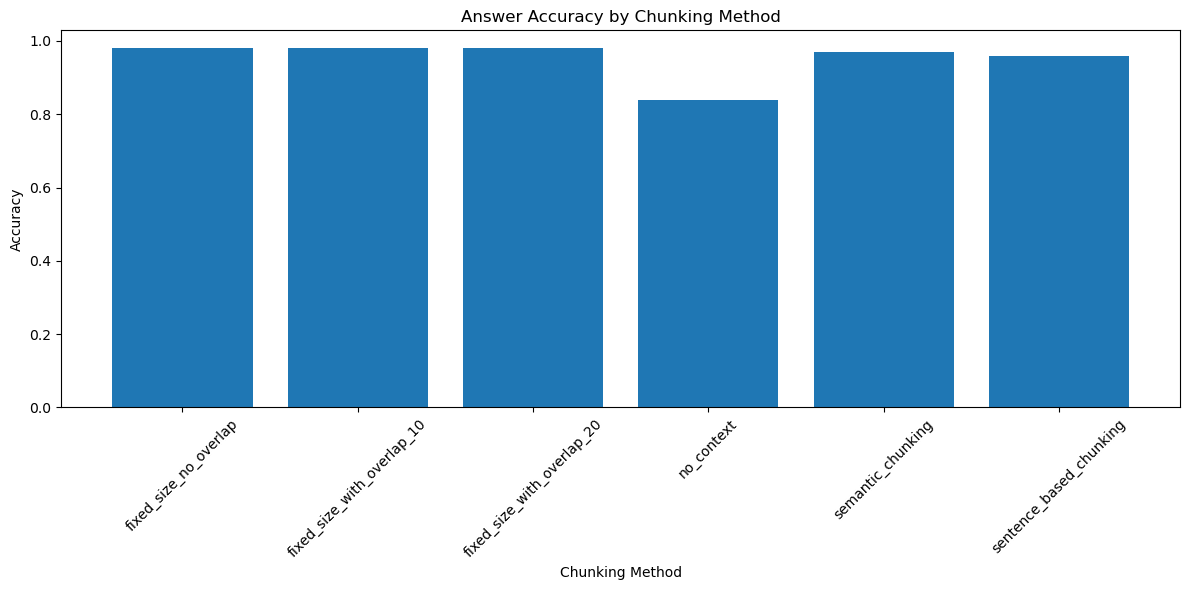

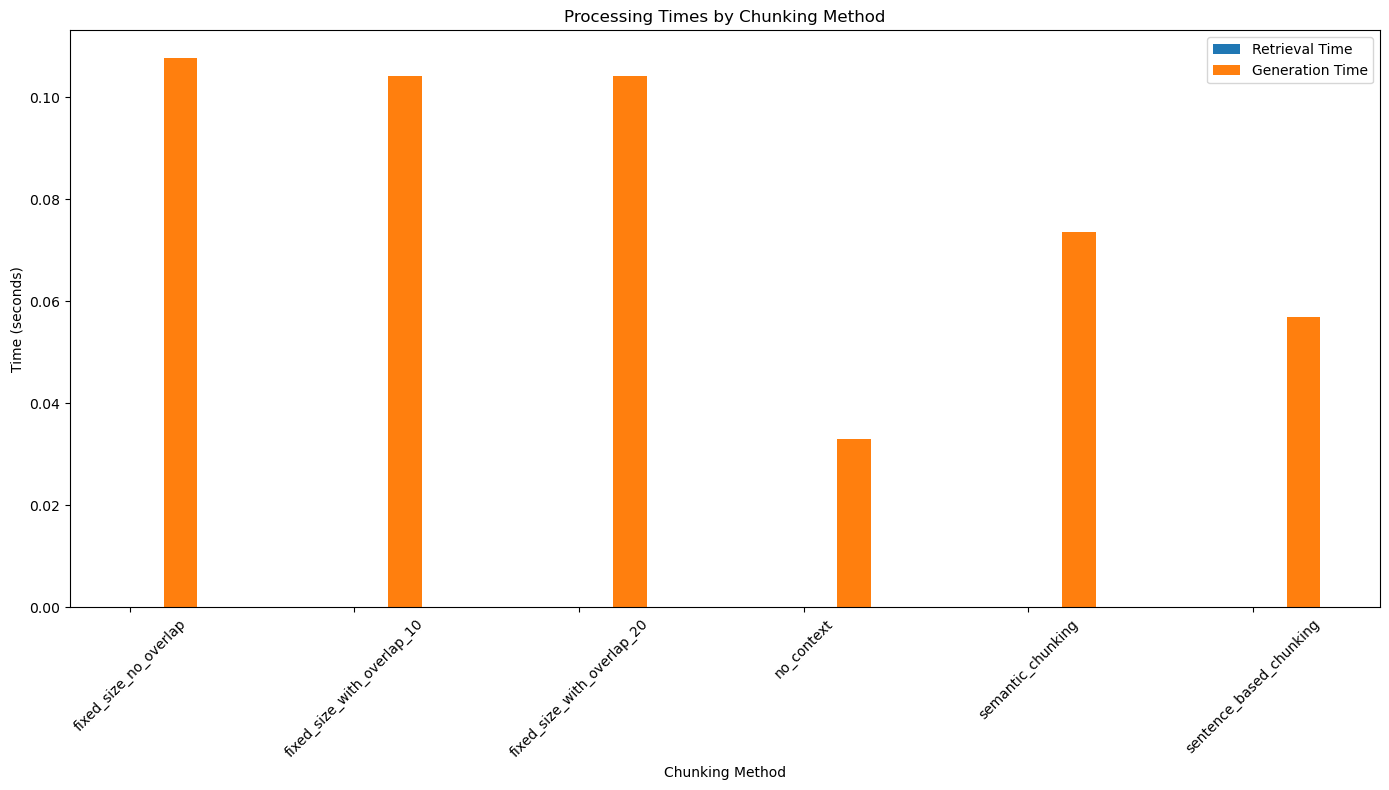

In [21]:
# # Step 4: Analyze and visualize results
df, aggregates = analyze_results(results)
print("\nExperiment completed! Results saved to chunking_experiment_results.csv")
